In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
%matplotlib inline

In [52]:
# Set the random seed
np.random.seed(123)
# Read in the data
data = pd.read_csv('data/medicare_county_level/cleaned_medicare_county_all.csv')
data['year'] = data['year'] - 2007
# Subset 40 randomly selected states
selected_states = np.random.choice(data['state'].unique(), size = 40, replace = False)
data['select_state'] = data['state'].apply(lambda x: 1 if x in selected_states else 0)
train_set = data.loc[data['select_state'] == 1, :]
# Drop rows with missing target value
train_set = train_set.dropna(axis = 0, subset = ['actual_per_capita_costs'])
# Get a list of unique counties
unique_counties = train_set['state_and_county_fips_code'].unique()

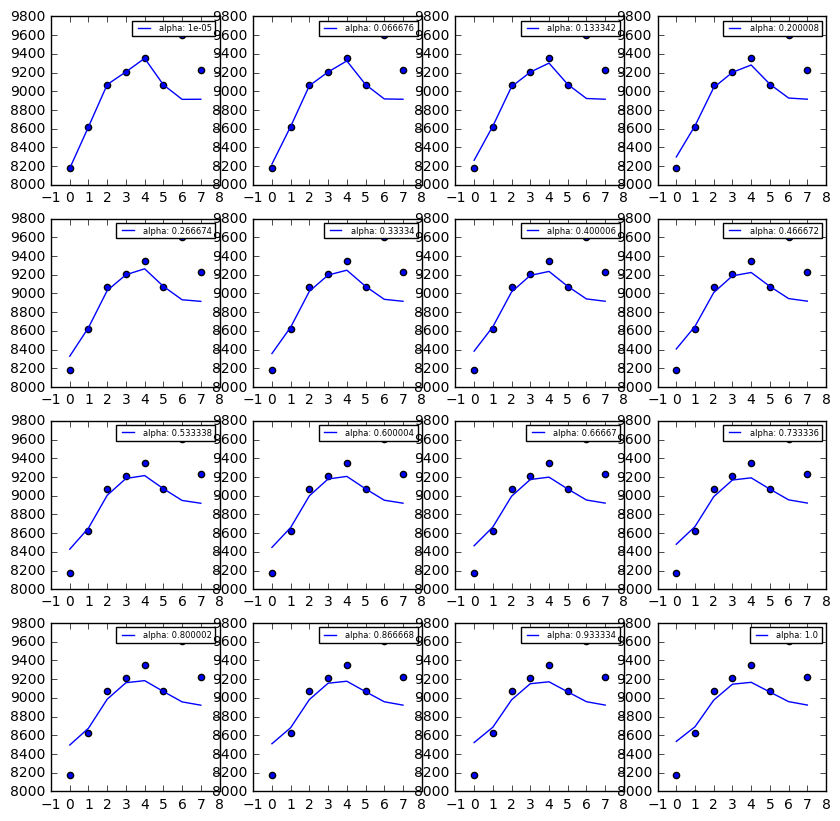

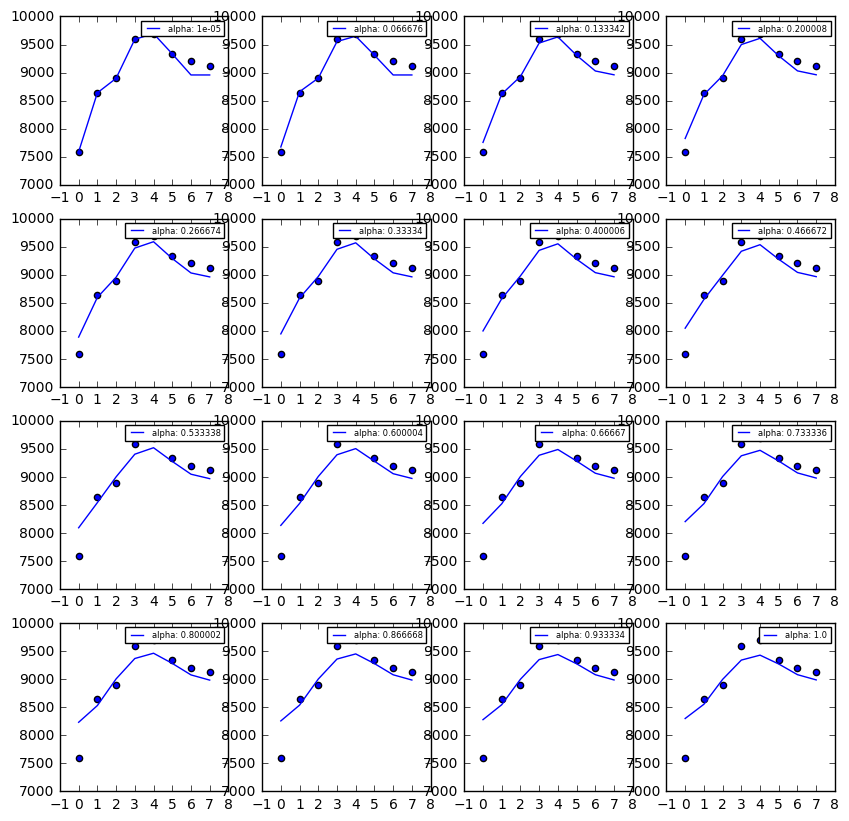

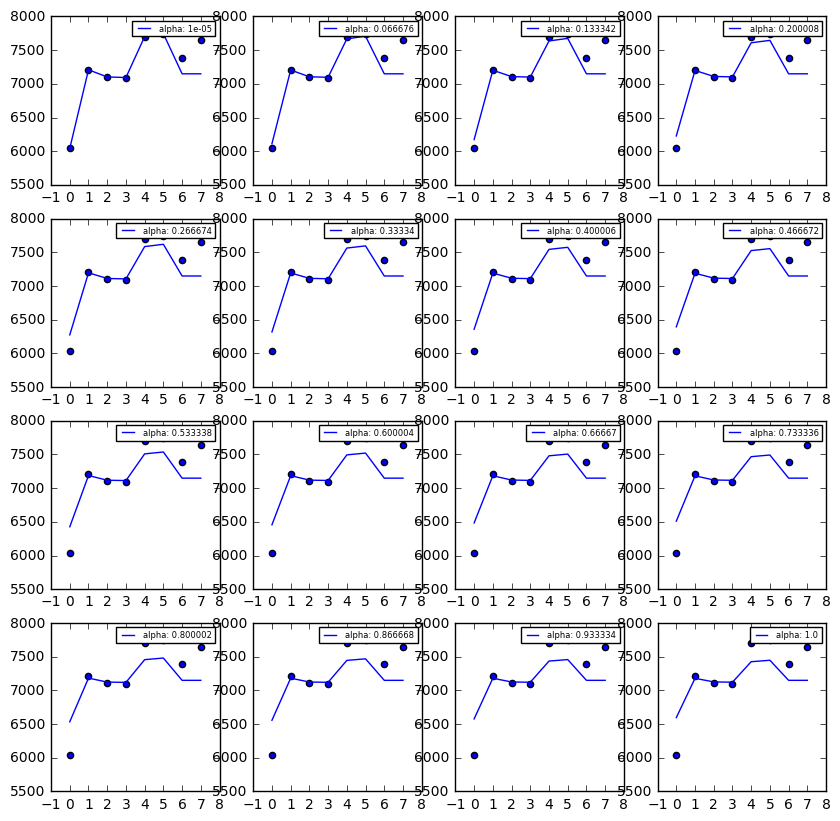

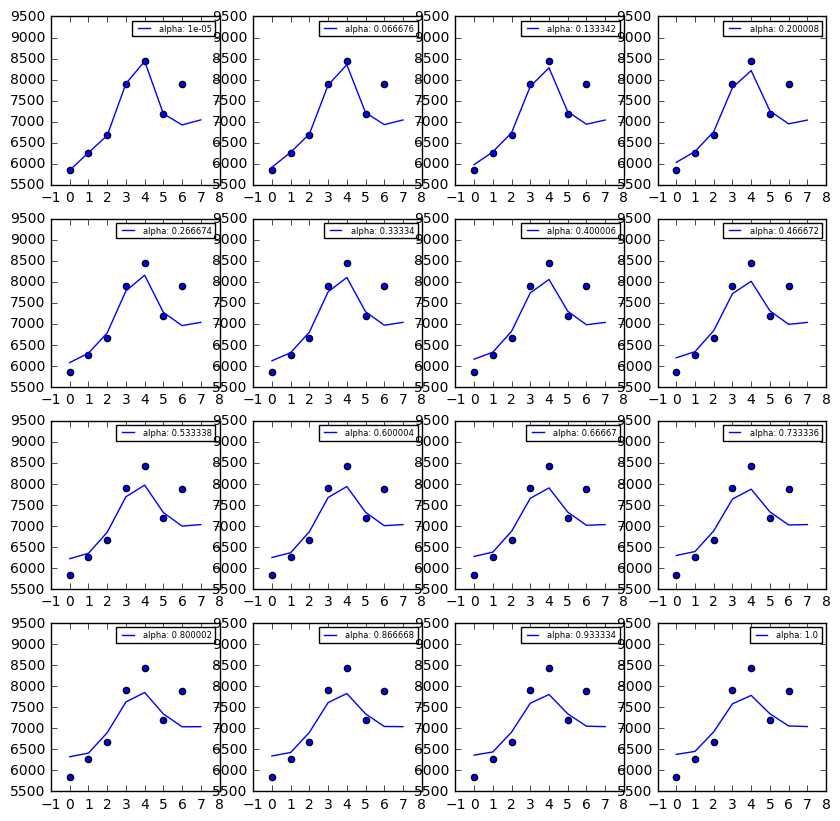

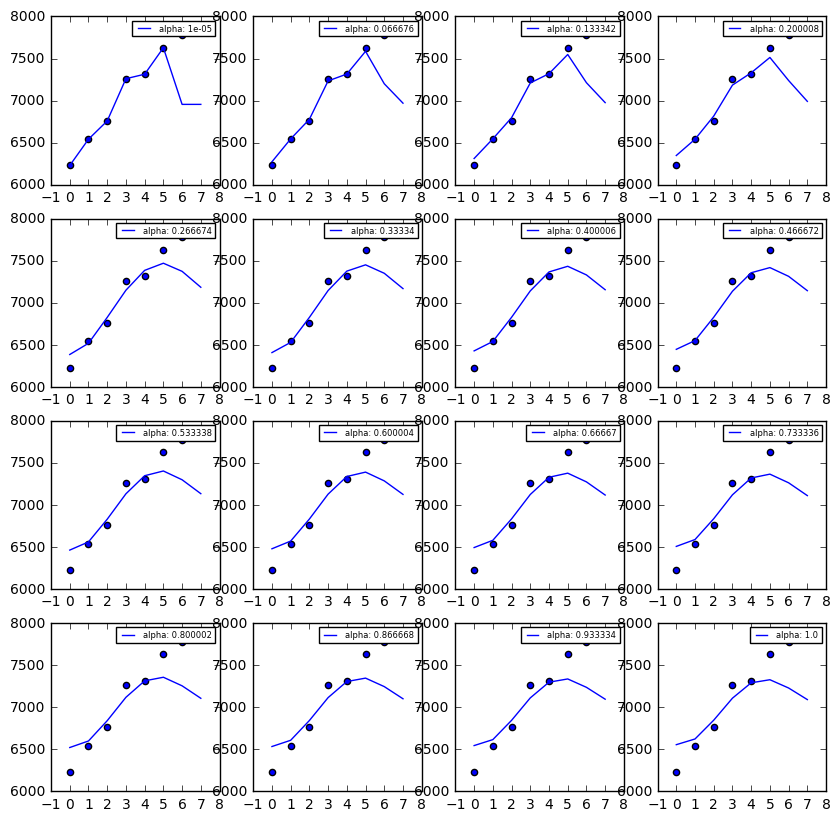

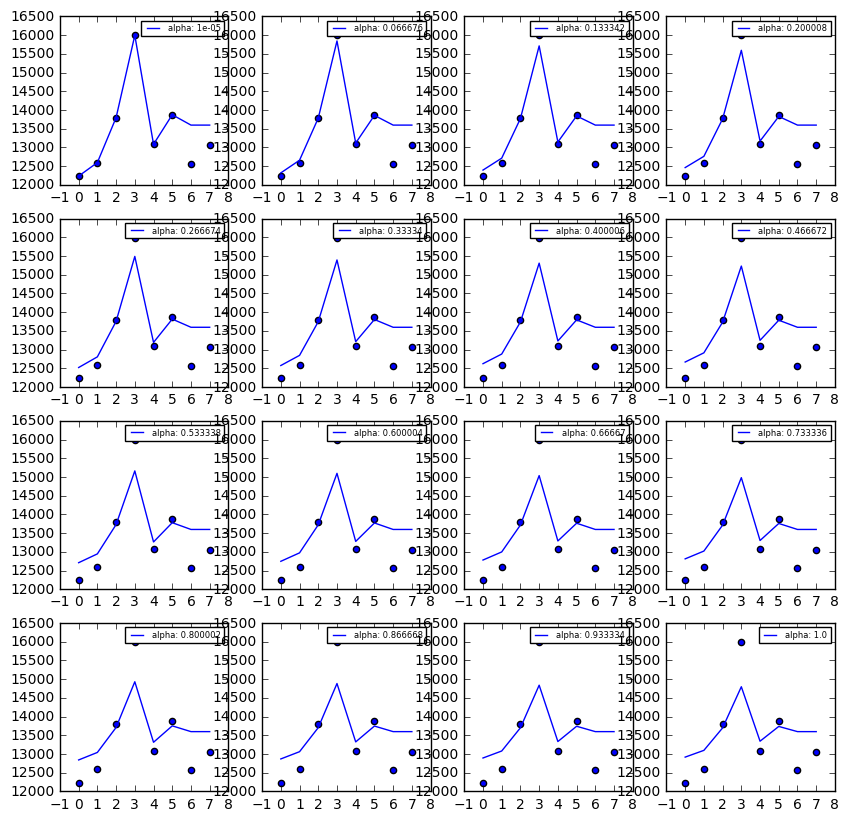

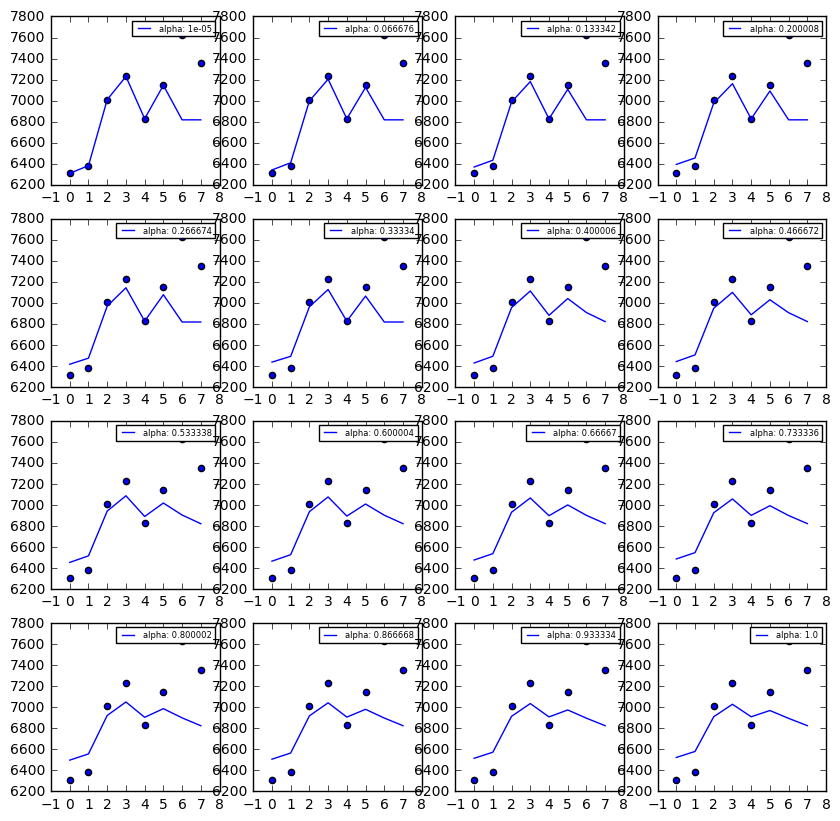

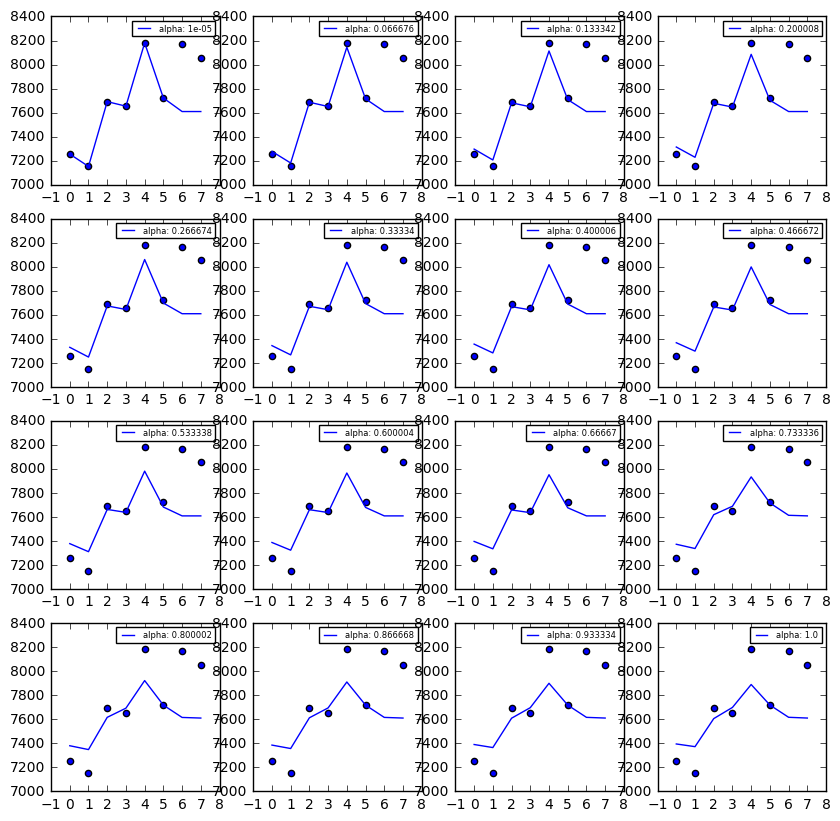

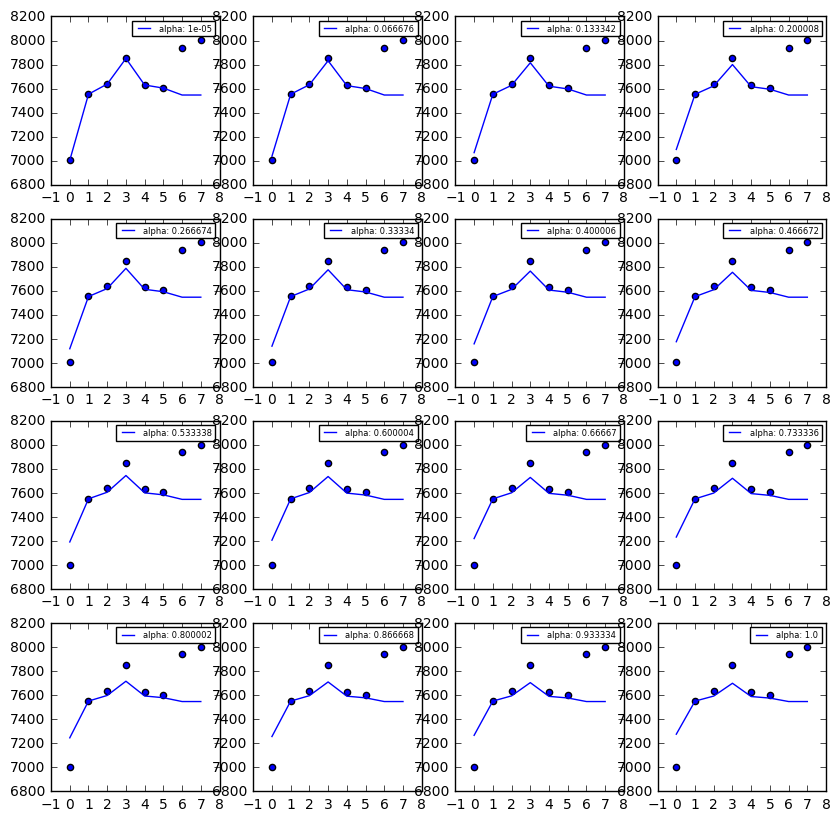

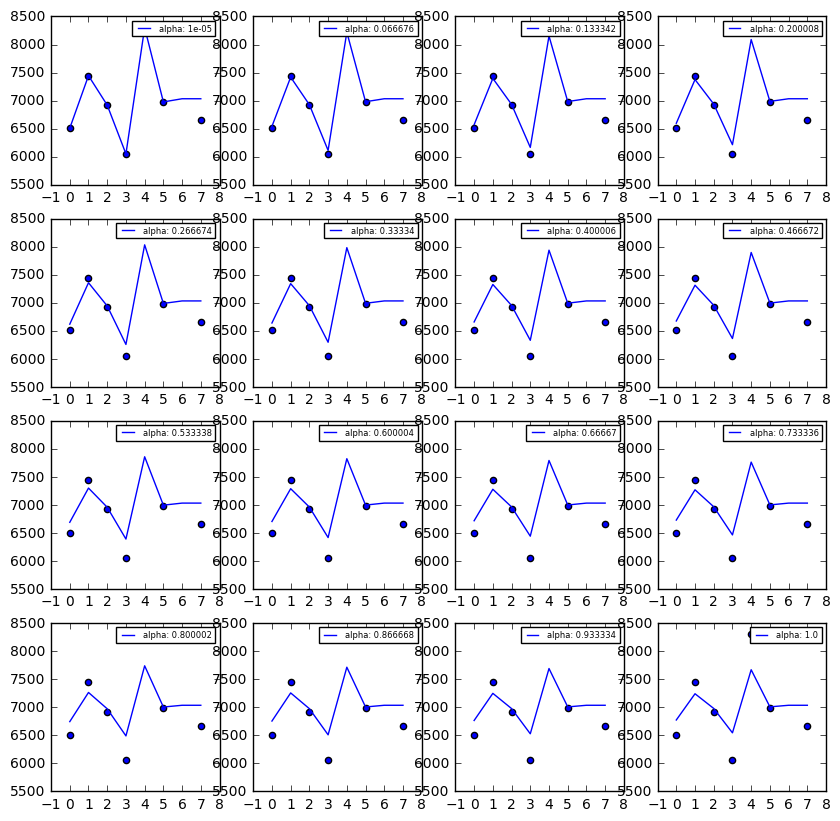

In [64]:
# Plot the impact of changing alpha on forecast for 16 random counties
for i in xrange(10):
    fig = plt.figure(figsize = (10,10))
    cty = np.random.choice(unique_counties, size = 1)[0]
    cty_data = train_set.loc[train_set['state_and_county_fips_code'] == cty, ['actual_per_capita_costs', 'year']]
    actual_costs = cty_data['actual_per_capita_costs'].values

    # Plot the changes in predictions based on alpha
    alphas = np.linspace(0.00001,1,16)
    for i, a in enumerate(alphas):
        ax = fig.add_subplot(4,4,i+1)
        # Get the train and target values for the county
        X_train = cty_data.loc[cty_data['year'] < 6, 'year'].values
        X_train = X_train.reshape(X_train.shape[0], 1)
        y_train = cty_data.loc[cty_data['year'] < 6, 'actual_per_capita_costs'].values
        # Get the test data for 2013-14
        X_test = np.array([[6], [7]])
        y_test = cty_data.loc[cty_data['year'] > 5, 'actual_per_capita_costs'].values
        # Build a Gaussian Process Regression Model for the county
        gp = GaussianProcessRegressor(alpha = a, kernel = RBF(), normalize_y = True)
        gp.fit(X_train, y_train)
        predictions = gp.predict(np.arange(8).reshape(8,1))
        # Plot the data
        ax.scatter(range(8), actual_costs)
        ax.plot(range(8), predictions, label = 'alpha: {}'.format(a))
        ax.legend(fontsize = 6)
    fig.show()

In [78]:
# Find the impact of alpha on model error
counties = np.random.choice(data['state_and_county_fips_code'].unique(), size = 500, replace = False)
data['selection'] = data['state_and_county_fips_code'].apply(lambda x: 1 if x in counties else 0)
subset = data.loc[data['selection'] == 1, :]
subset = subset.dropna(axis = 0, subset = ['actual_per_capita_costs'])
alphas = np.linspace(0.001, 2)
errors = []
for a in alphas:
    predictions = np.zeros(500)
    actual = np.zeros(500)
    for i, cty in enumerate(counties):
        cty_data = subset.loc[subset['state_and_county_fips_code'] == cty, ['actual_per_capita_costs', 'year']]
        X_train = cty_data.loc[cty_data['year'] < 6, 'year'].values
        X_train = X_train.reshape(X_train.shape[0], 1)
        y_train = cty_data.loc[cty_data['year'] < 6, 'actual_per_capita_costs'].values
        y_test = cty_data.loc[cty_data['year'] == 7, 'actual_per_capita_costs'].values
        if y_test:
            actual[i] = y_test
        else:
            actual[i] = np.nan

        gp = GaussianProcessRegressor(alpha = a, kernel = RBF(), normalize_y = True)
        gp.fit(X_train, y_train)
        prediction = gp.predict(np.array([[8]]))
        predictions[i] = prediction

    test_indices = np.where(np.isfinite(actual))

    error = np.sqrt(np.mean((predictions[test_indices] - actual[test_indices])**2))
    errors.append(error)

 /Users/brendandrew/anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning:fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.95368120e-05]), 'nit': 2, 'funcalls': 47}


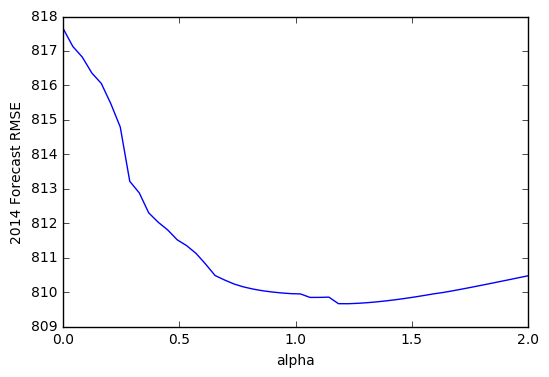

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(alphas, errors)
ax.set_xlabel('alpha')
ax.set_ylabel('2014 Forecast RMSE')
fig.show()

In [86]:
alphas[np.argmin(errors)]

1.224877551020408

In [92]:
# Find the impact of alpha on model error
counties = np.random.choice(data['state_and_county_fips_code'].unique(), size = 500, replace = False)
data['selection'] = data['state_and_county_fips_code'].apply(lambda x: 1 if x in counties else 0)
subset = data.loc[data['selection'] == 1, :]
subset = subset.dropna(axis = 0, subset = ['actual_per_capita_costs'])
length_scales = np.array([1, 50, 1000, 5000])
errors = []
for l in length_scales:
    predictions = np.zeros(500)
    actual = np.zeros(500)
    for i, cty in enumerate(counties):
        cty_data = subset.loc[subset['state_and_county_fips_code'] == cty, ['actual_per_capita_costs', 'year']]
        X_train = cty_data.loc[cty_data['year'] < 6, 'year'].values
        X_train = X_train.reshape(X_train.shape[0], 1)
        y_train = cty_data.loc[cty_data['year'] < 6, 'actual_per_capita_costs'].values
        y_test = cty_data.loc[cty_data['year'] == 7, 'actual_per_capita_costs'].values
        if y_test:
            actual[i] = y_test
        else:
            actual[i] = np.nan

        gp = GaussianProcessRegressor(alpha = 1.22, kernel = RBF(length_scale = l), normalize_y = True)
        gp.fit(X_train, y_train)
        prediction = gp.predict(np.array([[8]]))
        predictions[i] = prediction

    test_indices = np.where(np.isfinite(actual))

    error = np.sqrt(np.mean((predictions[test_indices] - actual[test_indices])**2))
    errors.append(error)

 /Users/brendandrew/anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning:fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00366325]), 'nit': 2, 'funcalls': 53}


In [93]:
errors

[847.21104554452006,
 855.25392943123688,
 855.14760499275485,
 854.07996963621849]

In [94]:
# Get the predictions for 500 counties
np.random.seed(123)
counties = np.random.choice(data['state_and_county_fips_code'].unique(), size = 500, replace = False)
data['selection'] = data['state_and_county_fips_code'].apply(lambda x: 1 if x in counties else 0)
subset = data.loc[data['selection'] == 1, :]
subset = subset.dropna(axis = 0, subset = ['actual_per_capita_costs'])
predictions = np.zeros(500)
actual = np.zeros(500)
for i, cty in enumerate(counties):
    cty_data = subset.loc[subset['state_and_county_fips_code'] == cty, ['actual_per_capita_costs', 'year']]
    X_train = cty_data.loc[cty_data['year'] < 6, 'year'].values
    X_train = X_train.reshape(X_train.shape[0], 1)
    y_train = cty_data.loc[cty_data['year'] < 6, 'actual_per_capita_costs'].values
    y_test = cty_data.loc[cty_data['year'] == 7, 'actual_per_capita_costs'].values
    if y_test:
        actual[i] = y_test
    else:
        actual[i] = np.nan
    gp = GaussianProcessRegressor(alpha = 1.22, kernel = RBF(), normalize_y = True)
    gp.fit(X_train, y_train)
    prediction = gp.predict(np.array([[8]]))
    predictions[i] = prediction

In [96]:
rmse_2014 = np.sqrt(np.mean((predictions - actual)**2))

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,    1.,
           0.,    0.,    1.,    2.,    2.,    3.,    8.,   10.,   30.,
          50.,   96.,  111.,  109.,   44.,   14.,    7.,    5.,    2.,
           1.,    1.,    1.]),
 array([-6442.88827107, -6148.82800203, -5854.76773299, -5560.70746394,
        -5266.6471949 , -4972.58692586, -4678.52665682, -4384.46638778,
        -4090.40611874, -3796.3458497 , -3502.28558065, -3208.22531161,
        -2914.16504257, -2620.10477353, -2326.04450449, -2031.98423545,
        -1737.92396641, -1443.86369736, -1149.80342832,  -855.74315928,
         -561.68289024,  -267.6226212 ,    26.43764784,   320.49791688,
          614.55818593,   908.61845497,  1202.67872401,  1496.73899305,
         1790.79926209,  2084.85953113,  2378.91980017]),
 <a list of 30 Patch objects>)

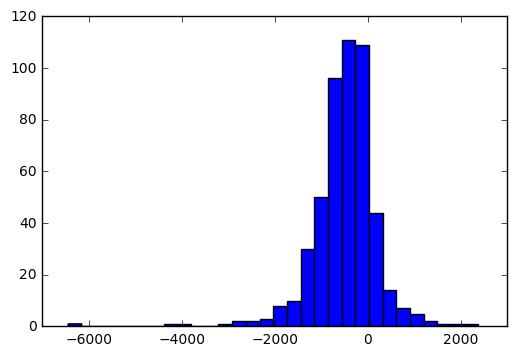

In [98]:
plt.hist((predictions - actual), bins = 30)